## Week 3 Homework
<b><u>Important Note:</b></u> <p>You can load the data however you would like, but keep the files in .GZ Format. 
If you are using orchestration such as Airflow or Prefect do not load the data into Big Query using the orchestrator.</br> 
Stop with loading the files into a bucket. </br></br>
<u>NOTE:</u> You can use the CSV option for the GZ files when creating an External Table</br>

<b>SETUP:</b></br>
Create an external table using the fhv 2019 data. </br>
Create a table in BQ using the fhv 2019 data (do not partition or cluster this table). </br>
Data can be found here: https://github.com/DataTalksClub/nyc-tlc-data/releases/tag/fhv </p>

I used Prefect to upload the data to gsc bucket.. Below is the code I used.:

```python
from pathlib import Path
import pandas as pd
from prefect import flow, task
from prefect_gcp.cloud_storage import GcsBucket
from random import randint
from prefect.tasks import task_input_hash
from datetime import timedelta


@task(retries=3, cache_key_fn=task_input_hash, cache_expiration=timedelta(days=1))
def fetch(dataset_url: str) -> pd.DataFrame:
    """Read taxi data from web into pandas DataFrame"""
    # if randint(0, 1) > 0:
    #     raise Exception

    df = pd.read_csv(dataset_url)
    return df


@task(log_prints=True)
def clean(df: pd.DataFrame) -> pd.DataFrame:
    """Fix dtype issues"""
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["dropOff_datetime"] = pd.to_datetime(df["dropOff_datetime"])
    print(df.head(2))
    print(f"columns: {df.dtypes}")
    print(f"rows: {len(df)}")
    return df


@task()
def write_local(df: pd.DataFrame, dataset_file: str) -> Path:
    """Write DataFrame out locally as parquet file"""
    path = Path(f"data/fhv/{dataset_file}.csv.gz")
    df.to_csv(path, compression="gzip")
    return path


@task()
def write_gcs(path: Path) -> None:
    """Upload local parquet file to GCS"""
    gcs_block = GcsBucket.load("zoom-gcs")
    gcs_block.upload_from_path(from_path=path, to_path=path)
    return


@flow()
def etl_web_to_gcs(year: int, month: int) -> None:
    """The main ETL function"""
    dataset_file = f"fhv_tripdata_{year}-{month:02}"
   # https://github.com/DataTalksClub/nyc-tlc-data/releases/download/fhv/fhv_tripdata_2019-01.csv.gz
    dataset_url = f"https://github.com/DataTalksClub/nyc-tlc-data/releases/download/fhv/{dataset_file}.csv.gz"

    df = fetch(dataset_url)
    df_clean = clean(df)
    path = write_local(df_clean, dataset_file)
    write_gcs(path)


@flow()
def etl_parent_flow(months: list[int] = [1, 2], year: int = 2019):
    for month in months:
        etl_web_to_gcs(year, month)

if __name__ == "__main__":
    #color = "yellow"
    months = [i for i in range(1,13)]
    year = 2019
    etl_parent_flow(months, year)

```

To create the external table:

```sql
    -- Creating external table referring to gcs path
CREATE OR REPLACE EXTERNAL TABLE `dezoom2023.dezoomcampbq.external_fhv_tripdata`
OPTIONS (
  format = 'CSV',
  uris = ['gs://dtc_data_lake_dezoom2023/data/fhv/fhv_tripdata_2019-*.csv.gz']
); 
```
To create a table in BQ using the fhv 2019 data:

```sql
-- Create a non partitioned table from external table --
CREATE OR REPLACE TABLE dezoom2023.dezoomcampbq.fhv_tripdata_non_partitoned AS
SELECT * FROM dezoom2023.dezoomcampbq.external_fhv_tripdata;
```




## Question 1:
What is the count for fhv vehicle records for year 2019?
- 65,623,481
- 43,244,696
- 22,978,333
- 13,942,414

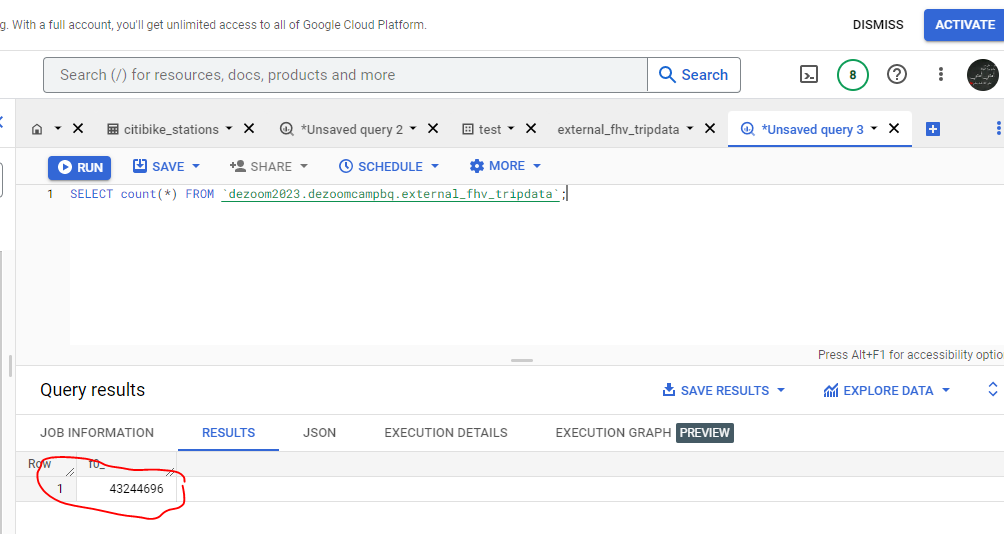

ans: 43,244,696



## Question 2:
Write a query to count the distinct number of affiliated_base_number for the entire dataset on both the tables.</br> 
What is the estimated amount of data that will be read when this query is executed on the External Table and the Table?

- 25.2 MB for the External Table and 100.87MB for the BQ Table
- 225.82 MB for the External Table and 47.60MB for the BQ Table
- 0 MB for the External Table and 0MB for the BQ Table
- 0 MB for the External Table and 317.94MB for the BQ Table 

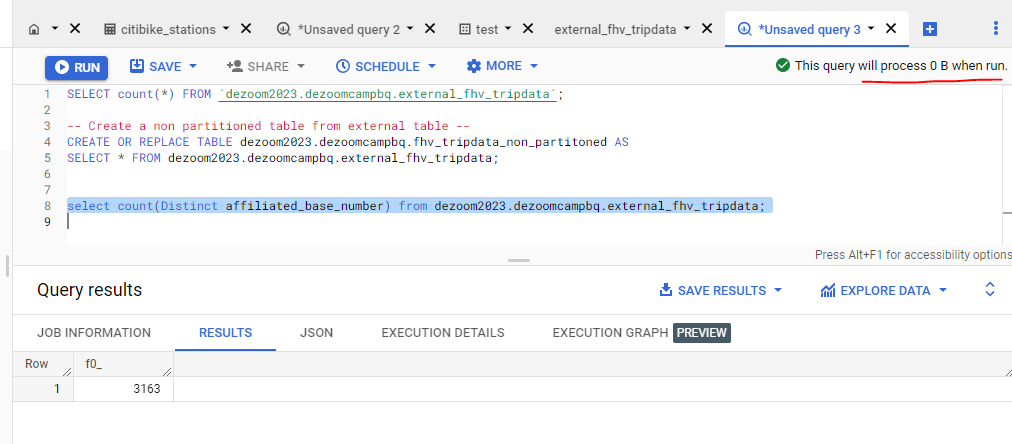

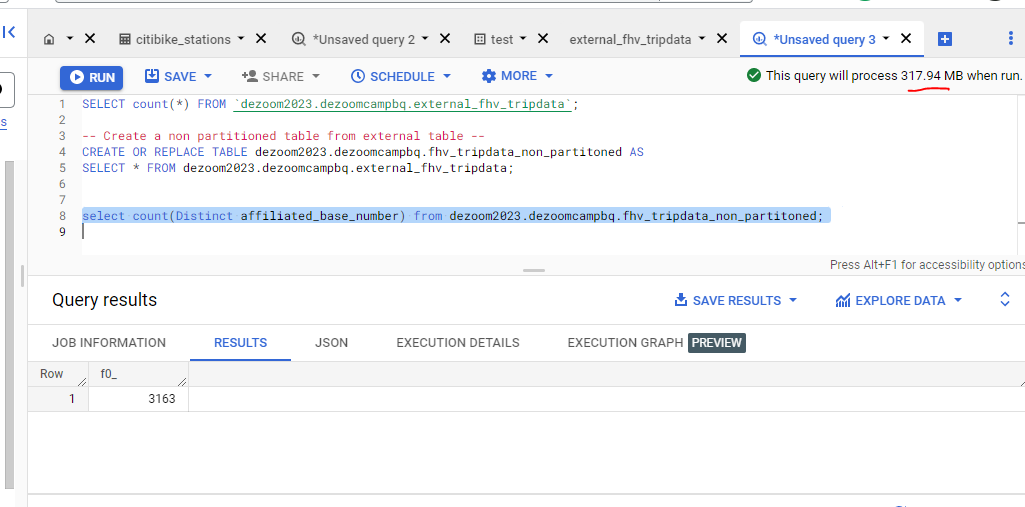

ans: - 0 MB for the External Table and 317.94MB for the BQ Table 




## Question 3:
How many records have both a blank (null) PUlocationID and DOlocationID in the entire dataset?
- 717,748
- 1,215,687
- 5
- 20,332

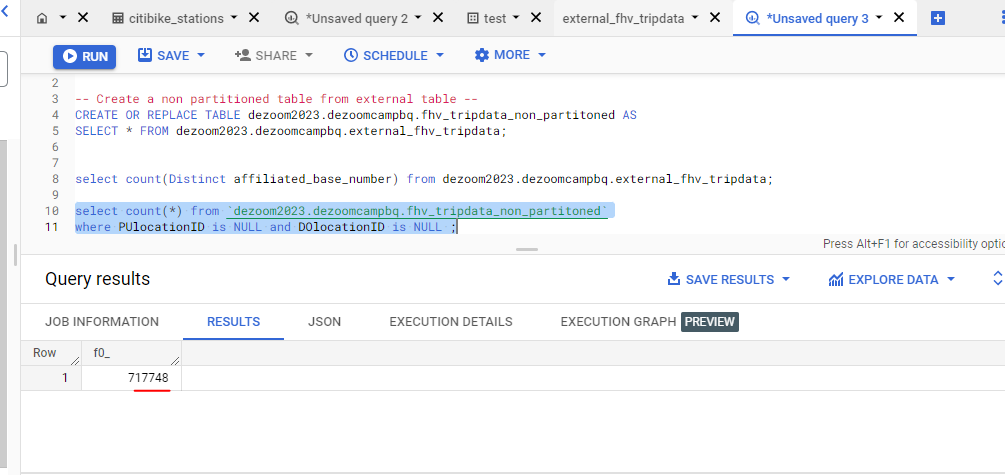

ans: - 717,748




## Question 4:
What is the best strategy to optimize the table if query always filter by pickup_datetime and order by affiliated_base_number?
- Cluster on pickup_datetime Cluster on affiliated_base_number
- Partition by pickup_datetime Cluster on affiliated_base_number
- Partition by pickup_datetime Partition by affiliated_base_number
- Partition by affiliated_base_number Cluster on pickup_datetime

ans: Partition by pickup_datetime Cluster on affiliated_base_number

By doing so, the queries that filter on the pickup_datetime column and order by the affiliated_base_number column will be much faster and more efficient. BigQuery will be able to take advantage of the partitioning and clustering to reduce the amount of data that needs to be scanned, resulting in improved query performance.



## Question 5:
Implement the optimized solution you chose for question 4. Write a query to retrieve the distinct affiliated_base_number between pickup_datetime 2019/03/01 and 2019/03/31 (inclusive).</br> 
Use the BQ table you created earlier in your from clause and note the estimated bytes. Now change the table in the from clause to the partitioned table you created for question 4 and note the estimated bytes processed. What are these values? Choose the answer which most closely matches.
- 12.82 MB for non-partitioned table and 647.87 MB for the partitioned table
- 647.87 MB for non-partitioned table and 23.06 MB for the partitioned table
- 582.63 MB for non-partitioned table and 0 MB for the partitioned table
- 646.25 MB for non-partitioned table and 646.25 MB for the partitioned table


Optimized solution:
    
```sql
-- Creating a partition and cluster table --
CREATE OR REPLACE TABLE dezoom2023.dezoomcampbq.fhv_partitioed_clutered
PARTITION BY DATE(pickup_datetime)
CLUSTER BY affiliated_base_number AS
SELECT * FROM dezoom2023.dezoomcampbq.fhv_tripdata_non_partitoned;

```

-Query to retrieve the distinct affiliated_base_number between pickup_datetime 2019/03/01 and 2019/03/31 (inclusive).?

```sql
select count(Distinct affiliated_base_number) from dezoom2023.dezoomcampbq.fhv_tripdata_non_partitoned 
where Date(pickup_datetime)  BETWEEN '2019-03-01' AND '2019-03-31' ;
```
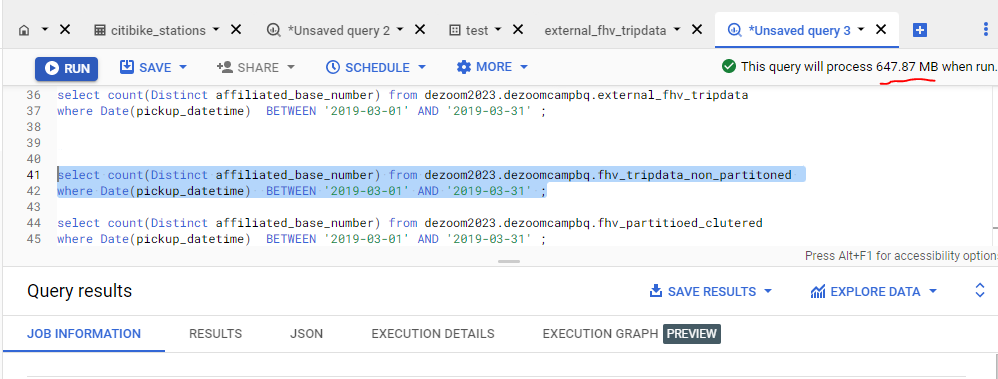

<br>

```sql
select count(Distinct affiliated_base_number) from dezoom2023.dezoomcampbq.fhv_partitioed_clutered
where Date(pickup_datetime)  BETWEEN '2019-03-01' AND '2019-03-31' ;
```
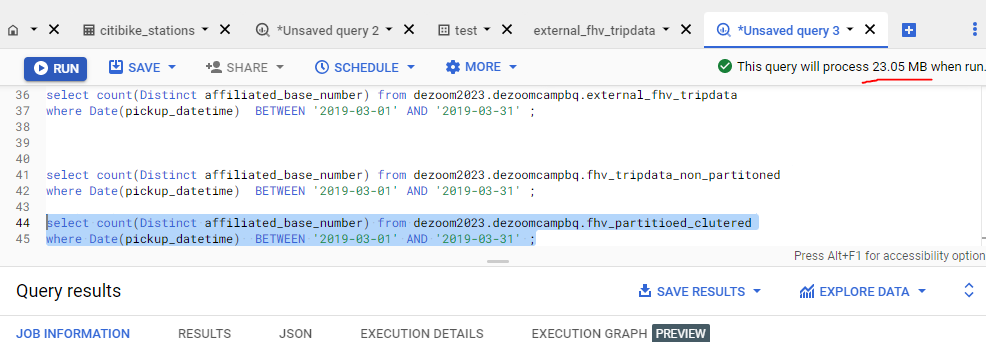


- ans:647.87 MB for non-partitioned table and 23.06 MB for the partitioned table





## Question 6: 
Where is the data stored in the External Table you created?

- Big Query
- GCP Bucket
- Container Registry
- Big Table

ans:  GCP Bucket




## Question 7:
It is best practice in Big Query to always cluster your data:
- True
- False

ans: False

Clustering in BigQuery can significantly improve query performance by organizing the data in a way that allows for more efficient scanning during query execution. However, it's not always necessary or the best choice. The decision to use clustering should be based on the specific use case and query patterns of your data.

Some factors to consider when deciding whether to cluster your data in BigQuery are:

Query patterns: If your queries frequently filter and sort data on the same columns, clustering on those columns can help to optimize performance.
Data size: If your table is relatively small, the benefits of clustering may not be significant enough to justify the additional setup and management overhead.
Write patterns: Clustered tables in BigQuery are optimized for efficient scanning during query execution, but may not be as optimized for fast writes. If your use case requires frequent writes to the table, it may be better to choose another optimization strategy.
In general, it's a good idea to assess your specific use case and query patterns and make a decision about clustering based on that information. If you have a large table with complex query patterns that frequently filter and sort data on specific columns, clustering on those columns may be a good optimization strategy. However, if your table is relatively small or your use case requires frequent writes to the table, clustering may not be the best choice.




## (Not required) Question 8:
A better format to store these files may be parquet. Create a data pipeline to download the gzip files and convert them into parquet. Upload the files to your GCP Bucket and create an External and BQ Table. 


Note: Column types for all files used in an External Table must have the same datatype. While an External Table may be created and shown in the side panel in Big Query, this will need to be validated by running a count query on the External Table to check if any errors occur. 


 
## Submitting the solutions

* Form for submitting: https://forms.gle/rLdvQW2igsAT73HTA
* You can submit your homework multiple times. In this case, only the last submission will be used. 

Deadline: 13 February (Monday), 22:00 CET


## Solution

We will publish the solution here
